In [3]:
from mcmc import BayesCalibrationMCMC
import json
import numpy as np
import pickle
import csv
import openturns as ot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from data_preparation  import preprocess_field_data

BASE_DIRECTORY = '/Users/edgarjaber/Desktop/codes.nosync/calibration_full/DATA/gv_900'


In [7]:
csv_file = BASE_DIRECTORY + '/field_data/ESTICOL.csv'
_ = json.load(open(BASE_DIRECTORY + '/meta_data/SG_cleaning_conditioning.json'))
cleaning_dates = [_['chemistry']['cleaning'][i]['time']/24 for i in range(len(_['chemistry']['cleaning']))]
operation_time = np.load(BASE_DIRECTORY + '/code_data/theta_t/LHS/t_gv.npy')

data, time_indices = preprocess_field_data(csv_file=csv_file, 
                                           operation_time=operation_time, 
                                           cleaning_dates=cleaning_dates)

with open(BASE_DIRECTORY +  '/metamodels/PCE/PCE_metamodel_MC_th.pkl', "rb") as f:
    unpickler = pickle.Unpickler(f)
    pce = unpickler.load()
pce = pce.getMetaModel()

In [8]:
step_size = 0.0005
proposal_distribution = ot.Uniform(-step_size, step_size)    

In [10]:
posterior_distributions = []
for i in range(len(data)):
    bayes = BayesCalibrationMCMC(data=data[i], data_time_indices=time_indices[i], metamodel=pce)
    posterior_distributions.append(bayes.mcmc_run(support_min=[0], support_max=[1], proposal=proposal_distribution, burning=1000, n_chains=2, sample_size=10000))

Running Markov chain 0
Running Markov chain 1
Gelman-Rubin convergence diagnostic: [1.00400131]
Running Markov chain 0
Running Markov chain 1
Gelman-Rubin convergence diagnostic: [1.03714657]
Running Markov chain 0
Running Markov chain 1
Gelman-Rubin convergence diagnostic: [1.02844958]


In [13]:
n_sample = 1000
posterior_distributions_samples = np.asarray([np.asarray(posterior_distributions[i].getSample(n_sample)).reshape(-1) for i in range(len(posterior_distributions))])

In [14]:
posterior_distrib_df = pd.DataFrame(posterior_distributions_samples.T, columns=['CC', 'CC-PC', 'PC'])

(0.0, 0.001)

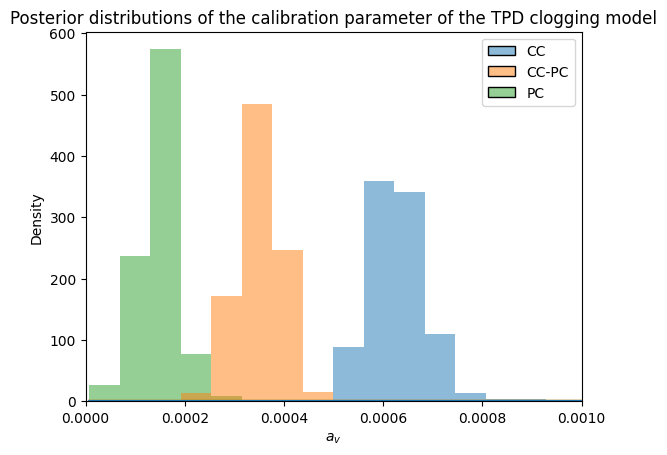

In [15]:
sns.histplot(posterior_distrib_df, kde=True, common_norm=True)
plt.title('Posterior distributions of the calibration parameter of the TPD clogging model')
plt.xlabel(r'$a_v$')
plt.ylabel('Density')
plt.xlim([0, 10e-4])